In [360]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # ポップアウトウィンドウを表示しないようにする
from ple.games.flappybird import FlappyBird
from ple import PLE
from collections import defaultdict
from itertools import chain

In [361]:
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps
    import moviepy.editor as mpy

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip, duration

In [362]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save('movie_flappy_bird_DQN.mp4')
    display(display_animation(anim, default_mode='loop'))

In [363]:
def make_graph(reward_per_epoch, lifetime_per_epoch):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    axL.set_title('lifetime')
    axL.grid(True)
    axL.plot(lifetime_per_epoch)
    axR.set_title('reward')
    axR.grid(True)
    axR.plot(reward_per_epoch)
    fig.show()

In [364]:
from collections import namedtuple

Transition = namedtuple('Transicion', ('state', 'action', 'next_state', 'reward'))

In [365]:
GAMMA = 0.99 # 時間割引率
MAX_STEPS = 1200 # 1試行のstep数(フレーム数)
NUM_EPISODES = 800 # 最大試行回数
PRINT_EVERY_EPISODE = 50
SHOW_GIF_EVERY_EPISODE = 100

In [366]:
class ReplayMemory:
    
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY #メモリの最大値
        self.memory = [] # 経験を保存するリスト
        self.index = 0 # 保存するindexを表す変数
    
    def push(self, state, action, state_next, reward):
        '''trasicion = (state, action, state_next, reward)をメモリ保存する'''
        
        if len(self.memory) < self.capacity:
            self.memory.append(None) # メモリが満タンじゃないときは足す
            
        # namedtupleのTransitionを用意し、値とフィールド名をペアにする
        self.memory[self.index] = Transition(state, action, state_next, reward)
            
        self.index = (self.index + 1) % self.capacity # 保存するindexを1つずらす
        
    def sample(self, batch_size):
        '''batch_sizeだけ、ランダムに取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在のmemoryの長さを返す'''
        return len(self.memory)

In [367]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [368]:
BATCH_SIZE = 32
CAPACITY = 10000

In [369]:
class Net(nn.Module):
    
    def __init__(self, num_states, num_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_states, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_actions)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [370]:
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions # 行動の数を取得
        
        # 経験を保存するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)
        
        # NNを構築
        self.model = Net(num_states, num_actions)
        
        print(self.model) # ネットワークの形を出力
        
        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        
    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを出力'''
        
        # ------------------------------------------------------------
        # 1.メモリサイズの確認
        # ------------------------------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return
        
        # ------------------------------------------------------------
        # 2. ミニバッチの作成
        # ------------------------------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)
        
        # 2.2 各変数をミニバッチに対応する形に変形
        # trainsicionsは1stepごとの(state, action. state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)xBATCH_SIZE
        # これをミニバッチにしたい
        # (state x BATCH_SIZE, action x BATCH_SIZE, state_next x BATCH_SIZE, reward x BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))
        
        # 2.3  各変数の要素をミニバッチに対応する形に変形する
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるが、
        # それを torch.FloatTensor of BATCH_SIZE x 4に変換する
        # cat は Concatenates(結合)のこと
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # ------------------------------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # ------------------------------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()
        
        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZE x 2]になっている
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが
        # 右か左かのindexを求め、それに対応するQ値をgatherで引っ張り出す
        state_action_values = self.model(state_batch).gather(1, action_batch)
        
        # 3.3 max{Q(s_t+1, a)}値を求める。ただし、次の状態があるかに注意。
        
        # flappybirdがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)
        
        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求める
        # そしてそのQ値を取り出します
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()
        
        # 3.4 教師となるQ値を、Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values
        
        # ------------------------------------------------------------
        # 4. 結合パラメータの更新　
        # ------------------------------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()
        
        # 4.2 損失関数を計算する (smooth_l1_lossはHuberloss)
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているから、unsqueezeで[minbatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad() # 勾配をリセット
        loss.backward() # バックプロパゲーションを計算
        self.optimizer.step() # 結合パラメータを更新
    
    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            self.model.eval() # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出す = max(1)[1]
            # .view(1, 1)は[torch.LongTensor of size 1] を size 1x1 に変換する
        
        else:
            # 0, 1の行動をランダムに返す
            action = torch.LongTensor(
                    [[random.randrange(self.num_actions)]])
            # actionは[torch.LongTensor of size 1x1]の形になる
        
        return action
    
    def brain_predict(self, state):
        self.model.eval() # ネットワークを推論モードに切り替える
        with torch.no_grad():
            action = self.model(state).max(1)[1].view(1, 1)
        return action

In [371]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)
        # エージェントが行動を決定するための頭脳を生成
        
    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()
        
    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)
    
    def predict_action(self, state):
        action = self.brain.brain_predict(state)
        return action

In [372]:
class Environment:
    
    def __init__(self):
        self.game = FlappyBird()
        self.env = PLE(self.game, fps=30, display_screen=False)
        self.num_states = len(self.game.getGameState())  # 8
        self.num_actions = len(self.env.getActionSet()) # 1
        self.agent = Agent(self.num_states, self.num_actions)
    
    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10) # 10試行分の成功したstep数を格納し、平均ステップ数を出力に利用
        complete_episodes = 0 # 195step以上連続で立ち続けた試行数
        episode_final = False # 最後の試行フラグ
        reward_per_epoch = []
        lifetime_per_epoch = []
        #frames = [] #最後の試行を動画にするための変数
        
        for episode in range(NUM_EPISODES): # 試行回数分繰り返す
            
            self.env.reset_game() # 環境の初期化
            observation = self.game.getGameState() # 観測をそのまま状態sとして使用
            state = observation
            state = np.array(list(self.get_relative_state(state)))
            #state = np.array(list(state.values()))
            state = torch.from_numpy(state).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
            # FloatTensor size 4 を size 1x4に変換
            state = torch.unsqueeze(state, 0)
            
            # record frame
            frames = [self.env.getScreenRGB()]
            
            cum_reward = 0  # このエピソードにおける累積報酬の和
            t = 0
            
            step = 0
            #for step in range(MAX_STEPS):
            while not self.env.game_over():
                step += 1
                #step+=1
                #if episode_final is True: 
                #    frames.append(self.env.getScreenRGB())
                
                action = self.agent.get_action(state, episode) # 行動を求める
                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                #print(self.env.act(action.item()))
                rew = self.env.act(self.env.getActionSet()[action])
                t += 1
                #observation_next, _, done, _ = self.env.step(action.item()) # rewardとinfoは使わないから _ にする
                observation_next = self.game.getGameState() 
                done = self.game.game_over()
                
                frames.append(self.env.getScreenRGB())
                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))
                    
                    # 罰則を与える
                    reward = torch.FloatTensor([-1.0])
                    
                    #if step < GOAL_FRAME:
                    #    reward = torch.FloatTensor(
                    #        [-1.0])  # 途中でこけたら罰則として報酬-1を与える
                    #    complete_episodes = 0  # 連続成功記録をリセット
                    #else:
                    #    reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                    #    complete_episodes = complete_episodes + 1  # 連続記録を更新
                else:
                    if rew > 0:
                        reward = torch.FloatTensor([1.0])
                    else:
                        reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    #reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = np.array(list(self.get_relative_state(state_next)))
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                # メモリに経験を追加
                cum_reward += rew
                
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next
                
                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    reward_per_epoch.append(cum_reward)
                    lifetime_per_epoch.append(step+1)
                    break
                    
            if episode_final is True:
                # 動画の保存と描画
                display_frames_as_gif(frames)
                break
            # 10連続で200step成功し続けたら成功
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True
                    
        
            # 50エピソード毎にlogを出力
            if episode % PRINT_EVERY_EPISODE == 0:
                print("Episode %d finished after %f time steps" % (episode, t))
                print("cumulated reward: %f" % cum_reward)
                #reward_per_epoch.append(cum_reward)
                #lifetime_per_epoch.append(t)
                #if len(frames) > GOAL_FRAME:
                #    print("len frames:", len(frames))
                #    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
                #    display(clip.ipython_display(fps=60, autoplay=1, loop=1))
                #    break
                #    #if self.graph == True:
                #    #    make_graph(reward_per_epoch, lifetime_per_epoch)
                

            # 100エピソード毎にアニメーションを作成
            if episode % SHOW_GIF_EVERY_EPISODE == 0:
                print("len frames:", len(frames))
                clip, duration = make_anim(frames, fps=60, true_image=True)
                clip = clip.rotate(-90)
                display(clip.ipython_display(fps=60, autoplay=1, loop=1, max_duration = duration))
                
        # グラフの作成
        make_graph(reward_per_epoch, lifetime_per_epoch)
    
    bucket_range_per_feature = {
        'next_next_pipe_bottom_y': 40,
        'next_next_pipe_dist_to_player': 512,
        'next_next_pipe_top_y': 40,
        'next_pipe_bottom_y': 20,
        'next_pipe_dist_to_player': 20,
        'next_pipe_top_y': 20,
        'player_vel': 4,
        'player_y': 16
    }
    
    def get_relative_state(self, state):
        # パイプの絶対位置の代わりに相対位置を使用する
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # アルファベット順に並び替える
        state_key = [k for k, v in sorted(state.items())]

        # 相対位置を返す
        state_idx = []
        for key in state_key:
            state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)
    
    def play(self):
        self.env.reset_game() # 環境の初期化
        observation = self.game.getGameState() # 観測をそのまま状態sとして使用
        state = observation
        state = np.array(list(self.get_relative_state(state)))
        state = torch.from_numpy(state).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
        # FloatTensor size 4 を size 1x4に変換
        state = torch.unsqueeze(state, 0)
        # record frame
        frames = [self.env.getScreenRGB()]
        
        while not self.env.game_over():
            action = self.agent.predict_action(state)
            # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
            # actionから.item()を指定して、中身を取り出す
            #print(self.env.act(action.item()))
            rew = self.env.act(self.env.getActionSet()[action])
            observation_next = self.game.getGameState() 
            done = self.game.game_over()
            frames.append(self.env.getScreenRGB())
        
        print("len frames:", len(frames))
        clip, duration = make_anim(frames, fps=60, true_image=True)
        clip = clip.rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, max_duration = duration))

Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


 34%|███▍      | 22/64 [00:00<00:00, 219.11it/s]

0 Episode: Finished after 63 steps：10試行の平均step数 = 6.3
Episode 0 finished after 62.000000 time steps
cumulated reward: -5.000000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 247.06it/s]


1 Episode: Finished after 63 steps：10試行の平均step数 = 12.6
2 Episode: Finished after 48 steps：10試行の平均step数 = 17.4
3 Episode: Finished after 45 steps：10試行の平均step数 = 21.9
4 Episode: Finished after 63 steps：10試行の平均step数 = 28.2
5 Episode: Finished after 45 steps：10試行の平均step数 = 32.7
6 Episode: Finished after 56 steps：10試行の平均step数 = 38.3
7 Episode: Finished after 63 steps：10試行の平均step数 = 44.6
8 Episode: Finished after 68 steps：10試行の平均step数 = 51.4
9 Episode: Finished after 63 steps：10試行の平均step数 = 57.7
10 Episode: Finished after 66 steps：10試行の平均step数 = 58.0
11 Episode: Finished after 74 steps：10試行の平均step数 = 59.1
12 Episode: Finished after 66 steps：10試行の平均step数 = 60.9
13 Episode: Finished after 63 steps：10試行の平均step数 = 62.7
14 Episode: Finished after 71 steps：10試行の平均step数 = 63.5
15 Episode: Finished after 71 steps：10試行の平均step数 = 66.1
16 Episode: Finished after 70 steps：10試行の平均step数 = 67.5
17 Episode: Finished after 63 steps：10試行の平均step数 = 67.5
18 Episode: Finished after 63 steps：10試行の平均step数 = 67.0
1

 24%|██▎       | 18/76 [00:00<00:00, 175.66it/s]

100 Episode: Finished after 75 steps：10試行の平均step数 = 115.1
Episode 100 finished after 74.000000 time steps
cumulated reward: -4.000000
len frames: 75


 99%|█████████▊| 75/76 [00:00<00:00, 220.82it/s]


101 Episode: Finished after 216 steps：10試行の平均step数 = 125.6
102 Episode: Finished after 77 steps：10試行の平均step数 = 122.5
103 Episode: Finished after 71 steps：10試行の平均step数 = 107.6
104 Episode: Finished after 105 steps：10試行の平均step数 = 111.8
105 Episode: Finished after 187 steps：10試行の平均step数 = 119.7
106 Episode: Finished after 107 steps：10試行の平均step数 = 123.6
107 Episode: Finished after 63 steps：10試行の平均step数 = 115.2
108 Episode: Finished after 303 steps：10試行の平均step数 = 127.1
109 Episode: Finished after 257 steps：10試行の平均step数 = 146.1
110 Episode: Finished after 219 steps：10試行の平均step数 = 160.5
111 Episode: Finished after 99 steps：10試行の平均step数 = 148.8
112 Episode: Finished after 99 steps：10試行の平均step数 = 151.0
113 Episode: Finished after 76 steps：10試行の平均step数 = 151.5
114 Episode: Finished after 248 steps：10試行の平均step数 = 165.8
115 Episode: Finished after 304 steps：10試行の平均step数 = 177.5
116 Episode: Finished after 63 steps：10試行の平均step数 = 173.1
117 Episode: Finished after 101 steps：10試行の平均step数 = 176.9
118 

 10%|█         | 7/70 [00:00<00:00, 68.43it/s]

200 Episode: Finished after 69 steps：10試行の平均step数 = 149.0
Episode 200 finished after 68.000000 time steps
cumulated reward: -4.000000
len frames: 69


 99%|█████████▊| 69/70 [00:00<00:00, 195.68it/s]


201 Episode: Finished after 405 steps：10試行の平均step数 = 181.6
202 Episode: Finished after 104 steps：10試行の平均step数 = 155.9
203 Episode: Finished after 102 steps：10試行の平均step数 = 144.8
204 Episode: Finished after 149 steps：10試行の平均step数 = 142.0
205 Episode: Finished after 108 steps：10試行の平均step数 = 142.4
206 Episode: Finished after 65 steps：10試行の平均step数 = 138.9
207 Episode: Finished after 176 steps：10試行の平均step数 = 146.3
208 Episode: Finished after 325 steps：10試行の平均step数 = 160.8
209 Episode: Finished after 63 steps：10試行の平均step数 = 156.6
210 Episode: Finished after 263 steps：10試行の平均step数 = 176.0
211 Episode: Finished after 289 steps：10試行の平均step数 = 164.4
212 Episode: Finished after 136 steps：10試行の平均step数 = 167.6
213 Episode: Finished after 63 steps：10試行の平均step数 = 163.7
214 Episode: Finished after 703 steps：10試行の平均step数 = 219.1
215 Episode: Finished after 105 steps：10試行の平均step数 = 218.8
216 Episode: Finished after 99 steps：10試行の平均step数 = 222.2
217 Episode: Finished after 99 steps：10試行の平均step数 = 214.5
21

  3%|▎         | 6/228 [00:00<00:03, 58.94it/s]

300 Episode: Finished after 227 steps：10試行の平均step数 = 255.9
Episode 300 finished after 226.000000 time steps
cumulated reward: 0.000000
len frames: 227


100%|█████████▉| 227/228 [00:00<00:00, 280.18it/s]


301 Episode: Finished after 297 steps：10試行の平均step数 = 262.9
302 Episode: Finished after 71 steps：10試行の平均step数 = 211.3
303 Episode: Finished after 371 steps：10試行の平均step数 = 240.5
304 Episode: Finished after 99 steps：10試行の平均step数 = 240.5
305 Episode: Finished after 135 steps：10試行の平均step数 = 189.6
306 Episode: Finished after 99 steps：10試行の平均step数 = 192.2
307 Episode: Finished after 228 steps：10試行の平均step数 = 200.2
308 Episode: Finished after 146 steps：10試行の平均step数 = 196.2
309 Episode: Finished after 144 steps：10試行の平均step数 = 181.7
310 Episode: Finished after 151 steps：10試行の平均step数 = 174.1
311 Episode: Finished after 416 steps：10試行の平均step数 = 186.0
312 Episode: Finished after 454 steps：10試行の平均step数 = 224.3
313 Episode: Finished after 305 steps：10試行の平均step数 = 217.7
314 Episode: Finished after 148 steps：10試行の平均step数 = 222.6
315 Episode: Finished after 113 steps：10試行の平均step数 = 220.4
316 Episode: Finished after 79 steps：10試行の平均step数 = 218.4
317 Episode: Finished after 151 steps：10試行の平均step数 = 210.7
3

  0%|          | 3/665 [00:00<00:22, 29.04it/s]

400 Episode: Finished after 664 steps：10試行の平均step数 = 649.4
Episode 400 finished after 663.000000 time steps
cumulated reward: 11.000000
len frames: 664


100%|█████████▉| 664/665 [00:02<00:00, 270.41it/s]


401 Episode: Finished after 1269 steps：10試行の平均step数 = 749.9
402 Episode: Finished after 1193 steps：10試行の平均step数 = 787.9
403 Episode: Finished after 99 steps：10試行の平均step数 = 757.0
404 Episode: Finished after 99 steps：10試行の平均step数 = 730.8
405 Episode: Finished after 63 steps：10試行の平均step数 = 565.4
406 Episode: Finished after 2020 steps：10試行の平均step数 = 742.6
407 Episode: Finished after 325 steps：10試行の平均step数 = 652.2
408 Episode: Finished after 701 steps：10試行の平均step数 = 699.9
409 Episode: Finished after 628 steps：10試行の平均step数 = 706.1
410 Episode: Finished after 334 steps：10試行の平均step数 = 673.1
411 Episode: Finished after 99 steps：10試行の平均step数 = 556.1
412 Episode: Finished after 628 steps：10試行の平均step数 = 499.6
413 Episode: Finished after 65 steps：10試行の平均step数 = 496.2
414 Episode: Finished after 367 steps：10試行の平均step数 = 523.0
415 Episode: Finished after 1003 steps：10試行の平均step数 = 617.0
416 Episode: Finished after 99 steps：10試行の平均step数 = 424.9
417 Episode: Finished after 99 steps：10試行の平均step数 = 402.3


  2%|▏         | 6/362 [00:00<00:06, 59.14it/s]

500 Episode: Finished after 361 steps：10試行の平均step数 = 262.1
Episode 500 finished after 360.000000 time steps
cumulated reward: 3.000000
len frames: 361


100%|█████████▉| 361/362 [00:01<00:00, 280.44it/s]


501 Episode: Finished after 113 steps：10試行の平均step数 = 266.1
502 Episode: Finished after 474 steps：10試行の平均step数 = 216.5
503 Episode: Finished after 217 steps：10試行の平均step数 = 231.0
504 Episode: Finished after 678 steps：10試行の平均step数 = 280.6
505 Episode: Finished after 176 steps：10試行の平均step数 = 291.6
506 Episode: Finished after 438 steps：10試行の平均step数 = 321.9
507 Episode: Finished after 552 steps：10試行の平均step数 = 354.9
508 Episode: Finished after 78 steps：10試行の平均step数 = 322.3
509 Episode: Finished after 530 steps：10試行の平均step数 = 361.7
510 Episode: Finished after 555 steps：10試行の平均step数 = 381.1
511 Episode: Finished after 136 steps：10試行の平均step数 = 383.4
512 Episode: Finished after 587 steps：10試行の平均step数 = 394.7
513 Episode: Finished after 72 steps：10試行の平均step数 = 380.2
514 Episode: Finished after 218 steps：10試行の平均step数 = 334.2
515 Episode: Finished after 70 steps：10試行の平均step数 = 323.6
516 Episode: Finished after 289 steps：10試行の平均step数 = 308.7
517 Episode: Finished after 176 steps：10試行の平均step数 = 271.1


  3%|▎         | 2/74 [00:00<00:03, 19.70it/s]

600 Episode: Finished after 73 steps：10試行の平均step数 = 369.8
Episode 600 finished after 72.000000 time steps
cumulated reward: -4.000000
len frames: 73


 99%|█████████▊| 73/74 [00:00<00:00, 191.68it/s]


601 Episode: Finished after 417 steps：10試行の平均step数 = 401.0
602 Episode: Finished after 1014 steps：10試行の平均step数 = 491.7
603 Episode: Finished after 108 steps：10試行の平均step数 = 333.6
604 Episode: Finished after 325 steps：10試行の平均step数 = 355.7
605 Episode: Finished after 639 steps：10試行の平均step数 = 397.6
606 Episode: Finished after 68 steps：10試行の平均step数 = 389.7
607 Episode: Finished after 99 steps：10試行の平均step数 = 348.1
608 Episode: Finished after 75 steps：10試行の平均step数 = 314.3
609 Episode: Finished after 2261 steps：10試行の平均step数 = 507.9
610 Episode: Finished after 438 steps：10試行の平均step数 = 544.4
611 Episode: Finished after 1053 steps：10試行の平均step数 = 608.0
612 Episode: Finished after 829 steps：10試行の平均step数 = 589.5
613 Episode: Finished after 361 steps：10試行の平均step数 = 614.8
614 Episode: Finished after 325 steps：10試行の平均step数 = 614.8
615 Episode: Finished after 474 steps：10試行の平均step数 = 598.3
616 Episode: Finished after 374 steps：10試行の平均step数 = 628.9
617 Episode: Finished after 1054 steps：10試行の平均step数 = 72

  0%|          | 2/1085 [00:00<00:57, 18.93it/s]

700 Episode: Finished after 1084 steps：10試行の平均step数 = 461.2
Episode 700 finished after 1083.000000 time steps
cumulated reward: 23.000000
len frames: 1084


100%|█████████▉| 1084/1085 [00:04<00:00, 248.13it/s]


701 Episode: Finished after 402 steps：10試行の平均step数 = 479.7
702 Episode: Finished after 741 steps：10試行の平均step数 = 472.5
703 Episode: Finished after 551 steps：10試行の平均step数 = 422.3
704 Episode: Finished after 69 steps：10試行の平均step数 = 384.9
705 Episode: Finished after 63 steps：10試行の平均step数 = 365.8
706 Episode: Finished after 296 steps：10試行の平均step数 = 362.9
707 Episode: Finished after 135 steps：10試行の平均step数 = 370.1
708 Episode: Finished after 440 steps：10試行の平均step数 = 402.9
709 Episode: Finished after 101 steps：10試行の平均step数 = 388.2
710 Episode: Finished after 217 steps：10試行の平均step数 = 301.5
711 Episode: Finished after 176 steps：10試行の平均step数 = 278.9
712 Episode: Finished after 1044 steps：10試行の平均step数 = 309.2
713 Episode: Finished after 484 steps：10試行の平均step数 = 302.5
714 Episode: Finished after 135 steps：10試行の平均step数 = 309.1
715 Episode: Finished after 66 steps：10試行の平均step数 = 309.4
716 Episode: Finished after 295 steps：10試行の平均step数 = 309.3
717 Episode: Finished after 8045 steps：10試行の平均step数 = 1100

  9%|▉         | 5/54 [00:00<00:00, 49.45it/s]

len frames: 53


 98%|█████████▊| 53/54 [00:00<00:00, 196.16it/s]


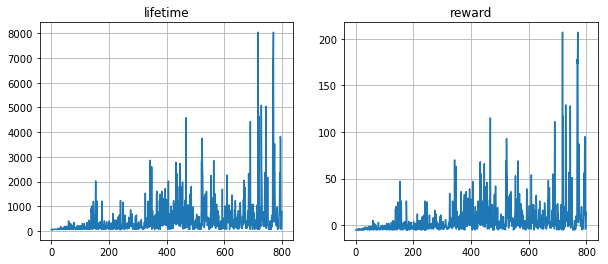

In [373]:
# mainクラス
flappy_env = Environment()
flappy_env.run()
flappy_env.play()

In [374]:
flappy_env.play()

 95%|█████████▌| 20/21 [00:00<00:00, 227.39it/s]

len frames: 20
